In [55]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [56]:
set.seed(1234)
options(digits=2)
stats <- c()

In [57]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [58]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [59]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as guide_positive, all others as guide_negative

In [60]:
mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "guide_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "guide_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
    }
    
    seurat_obj
}

### Load guide df

In [110]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-1a,DE4-1b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs7642977,DE2-2a,DE2-2b,DE2,ckd_de,targeting,rs7642977,CKD DE
rs35716097,DE19-1a,DE19-1b,DE19,ckd_de,targeting,rs35716097,CKD DE
rs10224210,DE17-1a,DE17-1b,DE17,ckd_de,targeting,rs10224210,CKD DE
rs2979488,DE15-1a,DE15-1b,DE15,ckd_de,targeting,rs2979488,CKD DE
Enh-29-9-LGALS3,LGALS3-2a,LGALS3-2b,LGALS3,de_control,targeting,LGALS3,Control DE


### Load Seurat file

In [69]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [70]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [71]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [72]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [73]:
perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

In [74]:
length(perturbed_cells_by_guide[[3]])

[1] 301

In [75]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

# Check DE for genes near SNPs

In [79]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [80]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210, rs77924615, rs35716097, rs11123169, rs4473129, rs4859682, rs9529913, rs55785724, rs2472297, rs11160318, rs12509595



In [281]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [283]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
chr_and_coords = str_split(df_nors_snps$gene, "_")
df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
colnames(df_dummy) <- c("chr", "start")

df_nors_snps$chr = paste0('chr', df_dummy$chr)
df_nors_snps$start_position  = as.numeric(df_dummy$start)
df_nors_snps$end_position    = as.numeric(df_dummy$start)
df_nors_snps$strand          = "*"
df_nors_snps$hgnc_symbol     = df_nors_snps$gene
df_nors_snps$chromosome_name = df_dummy$chr

In [284]:
select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
df_nors_snps = df_nors_snps[, select_cols]
df_snp_coords = rbind(df_snp_coords, df_nors_snps)

In [286]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [83]:
options(timeout=100000)
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
searchDatasets(mart = ensembl, pattern = "hsapiens")
mart <- useMart("ensembl")
mart <- useDataset("hsapiens_gene_ensembl", mart)

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
79,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


# Find neighbors of targets

In [86]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

In [87]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=m, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [287]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
BDKRB2 14 95204679 97244166 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FGF5 4 79266639 81336680 
FGFR3 4 793293 2808872 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
ICAM2 17 63002594 65020634 
IQGAP2 5 75403285 77708132 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
SLC34A1 5 176379235 178398848 
TKT 3 52224712 54256052 
UMOD 16 19333051 21356301 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979

In [288]:
list.save(neighbors_list, "/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")

## Run diffex on genes neighboring the snps w/ min_LFC = 0.10

In [289]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01

for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neigbors = neighbors_list[[target]]
    } else {
        neigbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neigbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        features = neigbors,
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = test_use,
        logfc.threshold = logfc_threshold,
        latent.vars = c("library", "donor"),
        only.pos = FALSE, 
        verbose = FALSE
    )
    # 
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(red("No DE genes", test_use,":", target, "\n"))
        next
    } 
    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(markers)
}

ANPEP ANPEP : CD13-1a,CD13-1b 
Guide+ = 564 ; Guide- = 45487 
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1  3.5e-05     -0.183 0.761 0.774         1  SEMA4B  ANPEP      tss Control TSS
2  2.0e-03      0.064 0.647 0.570         1    NGRN  ANPEP      tss Control TSS
3  6.0e-03      0.047 0.245 0.197         1   MESP1  ANPEP      tss Control TSS
4  7.4e-03      0.050 0.470 0.387         1   MFGE8  ANPEP      tss Control TSS
5  9.3e-03     -0.135 0.716 0.723         1   ANPEP  ANPEP      tss Control TSS
6  3.4e-02      0.044 0.587 0.506         1   ABHD2  ANPEP      tss Control TSS
7  6.1e-02      0.037 0.433 0.376         1   CRTC3  ANPEP      tss Control TSS
8  8.1e-02     -0.075 0.796 0.807         1    IDH2  ANPEP      tss Control TSS
9  1.1e-01     -0.021 0.092 0.108         1  GDPGP1  ANPEP      tss Control TSS
10 2.3e-01     -0.025 0.165 0.170         1  ZNF710  ANPEP      tss Control TSS
11 2.6e-01      0.015 0.152 0.129         1  PEX11A  ANPEP

In [290]:
#rownames(df_neighbor_de) <- df_neighbor_de$de_gene
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
129,2.6e-19,0.208,0.95,0.93,9.4e-15,CSTB,CSTB,de_control,Control DE
130,4.9e-04,0.038,0.77,0.72,1.0e+00,NDUFV3,CSTB,de_control,Control DE
131,9.5e-03,0.025,0.28,0.23,1.0e+00,RRP1,CSTB,de_control,Control DE
132,5.0e-02,-0.039,0.56,0.55,1.0e+00,PFKL,CSTB,de_control,Control DE
133,7.0e-02,-0.032,0.40,0.38,1.0e+00,PDE9A,CSTB,de_control,Control DE
134,1.2e-01,0.018,0.45,0.41,1.0e+00,RRP1B,CSTB,de_control,Control DE
135,1.3e-01,0.011,0.76,0.73,1.0e+00,PDXK,CSTB,de_control,Control DE
136,1.6e-01,-0.031,0.35,0.33,1.0e+00,PKNOX1,CSTB,de_control,Control DE
137,9.1e-01,-0.012,0.18,0.17,1.0e+00,WDR4,CSTB,de_control,Control DE


### Correct p-values by total number of comparisons

In [291]:
n_tests = length(flatten(neighbors_list))
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 1219


In [292]:
select_significant_p  = df_neighbor_de$p_val_adj_mine < 1
df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
129,2.6e-19,0.208,0.95,0.93,9.4e-15,CSTB,CSTB,de_control,Control DE,3.1e-16
130,4.9e-04,0.038,0.77,0.72,1.0e+00,NDUFV3,CSTB,de_control,Control DE,5.9e-01


In [293]:
head(df_neighbor_de, 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3.5e-05,-0.183,0.761,0.77,1.0e+00,SEMA4B,ANPEP,tss,Control TSS,4.3e-02
22,2.2e-09,0.327,0.846,0.73,8.2e-05,SNHG5,NT5E,tss,Control TSS,2.7e-06
23,3.1e-07,-0.167,0.698,0.73,1.1e-02,NT5E,NT5E,tss,Control TSS,3.8e-04
26,1.8e-05,-0.101,0.065,0.10,6.7e-01,PTGFR,FUBP1,tss,Control TSS,2.2e-02
36,1.2e-07,-0.113,0.350,0.46,4.4e-03,C15orf40,C15orf40,tss,Control TSS,1.5e-04
37,3.8e-07,0.161,0.966,0.96,1.4e-02,RPS17,C15orf40,tss,Control TSS,4.6e-04
44,1.7e-05,-0.063,0.150,0.22,6.2e-01,MAFF,MAFF,tss,Control TSS,2.1e-02
66,2.7e-37,0.220,1.000,1.00,9.9e-33,FTH1,FTH1,de_control,Control DE,3.3e-34
67,1.7e-14,0.112,0.865,0.81,6.1e-10,TMEM258,FTH1,de_control,Control DE,2.0e-11


## Volcano Plot

In [294]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


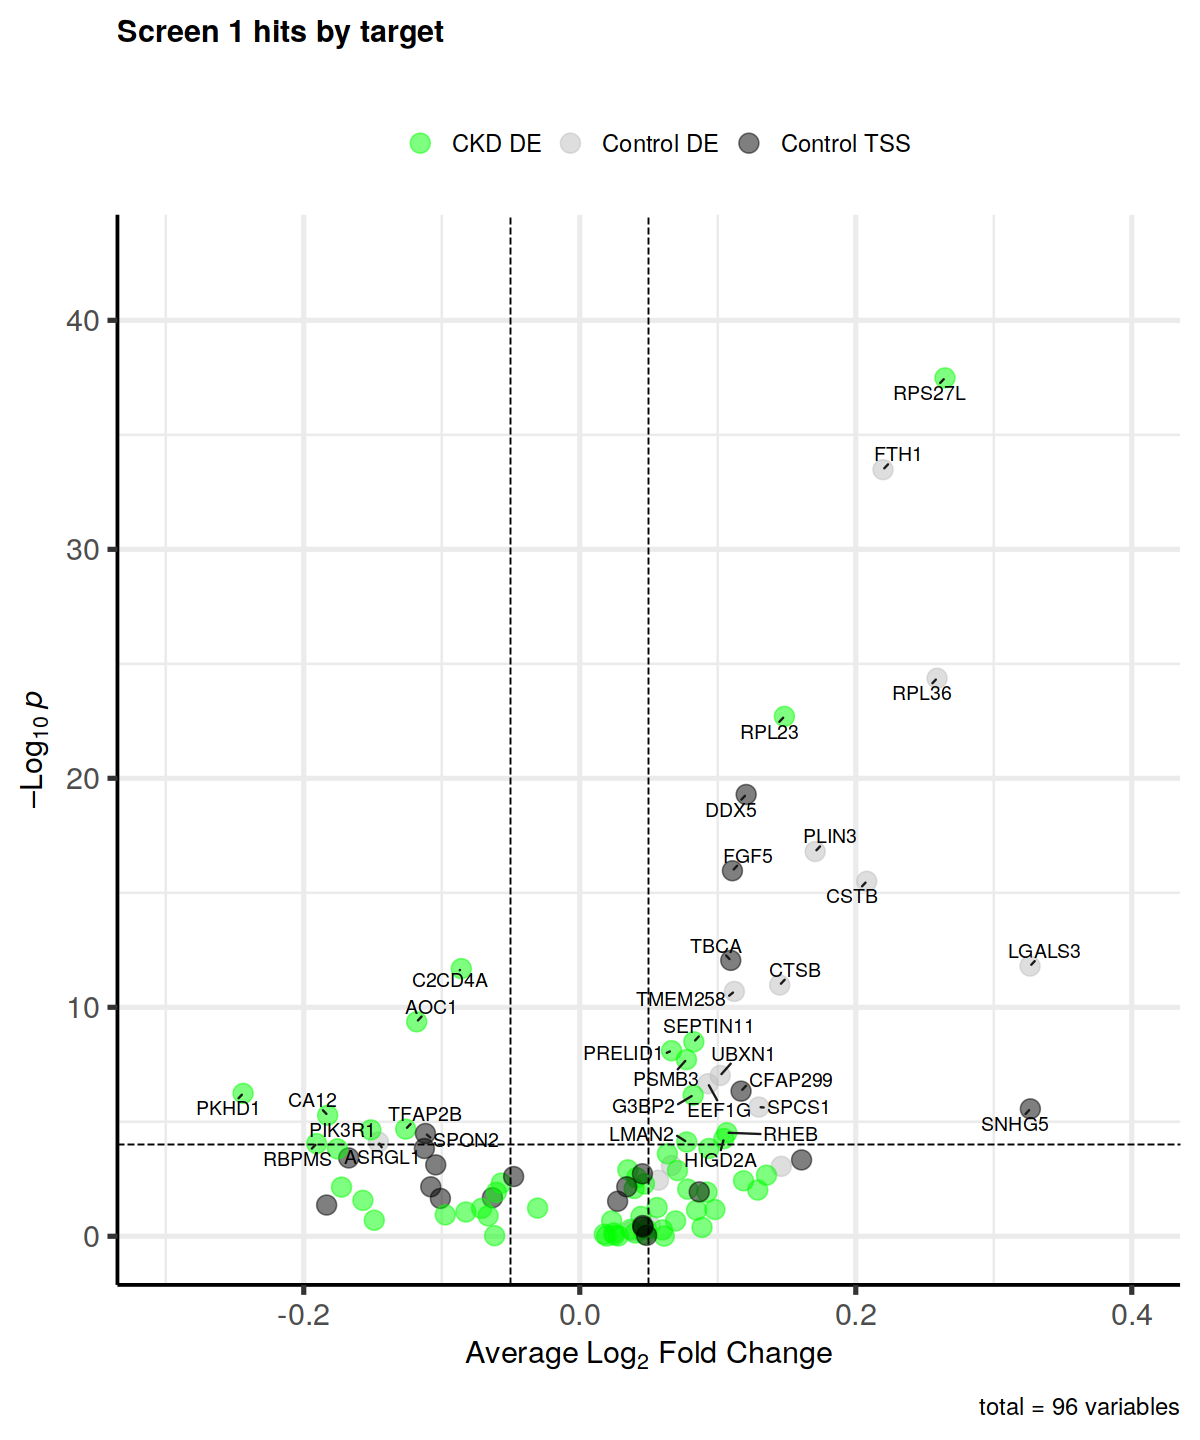

In [323]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = '', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))
                

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

# Inpect DE results

Print top high-confidence hits

In [301]:
df_neighbor_de %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.7e-41,0.265,0.98,0.96,9.8e-37,RPS27L,DE22,ckd_de,CKD DE,3.3e-38
2,2.7e-37,0.220,1.00,1.00,9.9e-33,FTH1,FTH1,de_control,Control DE,3.3e-34
3,3.5e-28,0.259,0.99,0.98,1.3e-23,RPL36,PLIN3,de_control,Control DE,4.3e-25
4,1.6e-26,0.148,0.99,0.98,5.9e-22,RPL23,DE20,ckd_de_no_rs,CKD DE,2.0e-23
5,4.2e-23,0.121,0.95,0.94,1.5e-18,DDX5,ICAM2,tss,Control TSS,5.1e-20
6,1.3e-20,0.171,0.71,0.63,4.7e-16,PLIN3,PLIN3,de_control,Control DE,1.6e-17
7,8.9e-20,0.111,0.24,0.14,3.3e-15,FGF5,FGF5,tss,Control TSS,1.1e-16
8,2.6e-19,0.208,0.95,0.93,9.4e-15,CSTB,CSTB,de_control,Control DE,3.1e-16
9,7.3e-16,0.109,0.94,0.92,2.7e-11,TBCA,IQGAP2,tss,Control TSS,8.9e-13


## Print top hits w/o log FC filtering

In [308]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

In [314]:
#df_top_hits %>% filter(label == "Control TSS")
#df_top_hits %>% filter(label == "Control DE")
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.085,7.2e-02,CKD DE
DE4,TAF9,0.019,9.8e-01,CKD DE
DE7,TNFRSF10D,0.129,9.6e-03,CKD DE
DE7,TNFRSF10B,0.098,6.8e-02,CKD DE
DE9,HSP90AB1,0.135,2.1e-03,CKD DE
DE9,DNPH1,0.119,3.8e-03,CKD DE
DE10,ODC1,0.056,5.6e-02,CKD DE
DE11,RHEB,0.071,1.4e-03,CKD DE
DE12,SEPTIN11,0.078,8.8e-03,CKD DE


## Print top hits w/ avg LogFC >0

In [315]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t) & (avg_log2FC > 0)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL   
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

Skipping  ANPEP 
Skipping  FUBP1 
Skipping  MAFF 
Skipping  DE5 
Skipping  DE16 
Skipping  UMOD 


In [316]:
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.085,7.2e-02,CKD DE
DE4,TAF9,0.019,9.8e-01,CKD DE
DE7,TNFRSF10D,0.129,9.6e-03,CKD DE
DE7,TNFRSF10B,0.098,6.8e-02,CKD DE
DE9,HSP90AB1,0.135,2.1e-03,CKD DE
DE9,DNPH1,0.119,3.8e-03,CKD DE
DE10,ODC1,0.056,5.6e-02,CKD DE
DE11,RHEB,0.071,1.4e-03,CKD DE
DE12,SEPTIN11,0.078,8.8e-03,CKD DE


# Visualize Knockdowns

## TSS controls

[1] "ANPEP"
CD13-1a   390 
CD13-1b   564 
Guide+ = 564 ; Guide- = 45487 
[1] "CD55"
CD55-1a   301 
CD55-1b   466 
Guide+ = 466 ; Guide- = 45585 
[1] "NT5E"
CD73-1a   344 
CD73-1b   474 
Guide+ = 474 ; Guide- = 45577 
[1] "FUBP1"
FUBP1-1a   234 
FUBP1-1b   372 
Guide+ = 372 ; Guide- = 45679 
[1] "C15orf40"
C15orf40-1a   377 
C15orf40-1b   526 
Guide+ = 526 ; Guide- = 45525 
[1] "MAFF"
MAFF-1a   295 
MAFF-1b   406 
Guide+ = 406 ; Guide- = 45645 
[1] "IQGAP2"
IQGAP2-1a   739 
IQGAP2-2a   1415 
IQGAP2-1b   1715 
IQGAP2-2b   2091 
Guide+ = 2091 ; Guide- = 43960 
[1] "FGFR3"
FGFR3-1a   635 
FGFR3-2a   1577 
FGFR3-1b   1925 
FGFR3-2b   2170 
Guide+ = 2170 ; Guide- = 43881 
[1] "HIST1H4H"
HIST1H4H-1a   276 
HIST1H4H-2a   1134 
HIST1H4H-1b   1257 
HIST1H4H-2b   1569 
Guide+ = 1569 ; Guide- = 44482 
[1] "ICAM2"
ICAM2-1a   1011 
ICAM2-2a   1685 
ICAM2tss-1a   2524 
ICAM2-1b   2794 
ICAM2-2b   2979 
ICAM2tss-1b   3216 
Guide+ = 3216 ; Guide- = 42835 
[1] "UMOD"
UMOD-1a   796 
UMOD-1b   1116 
Guide

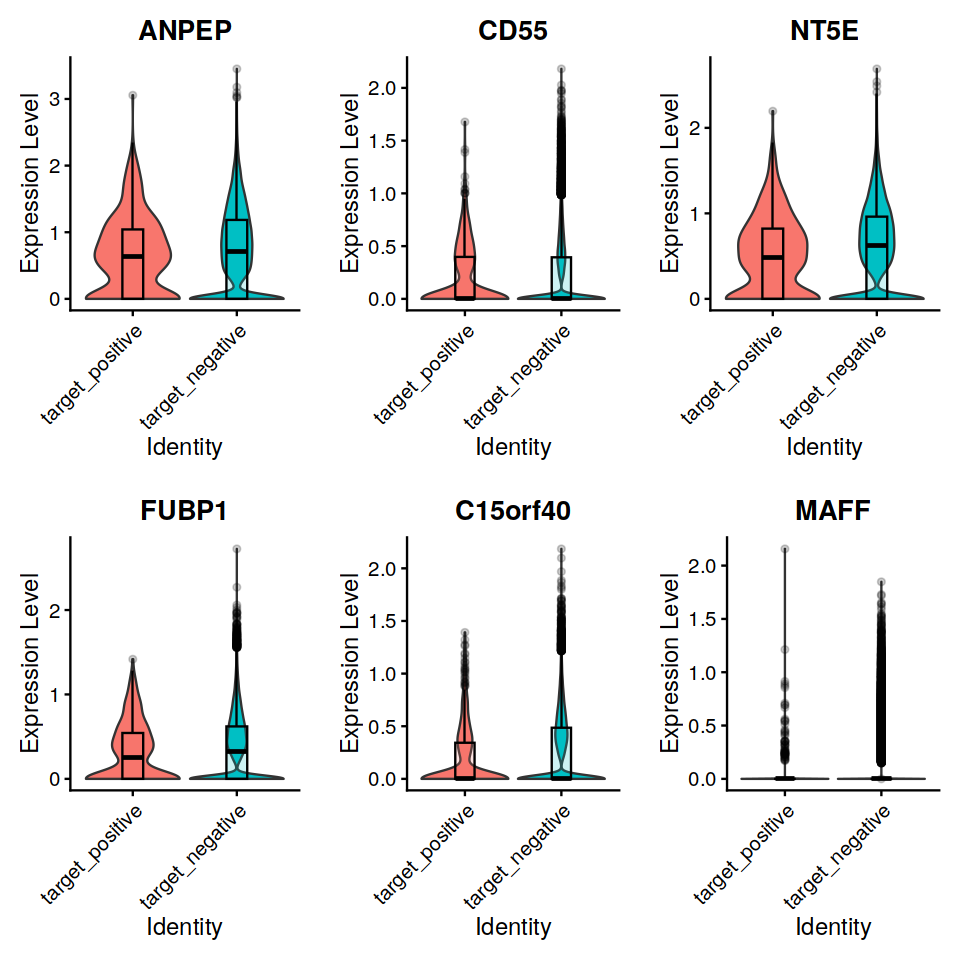

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

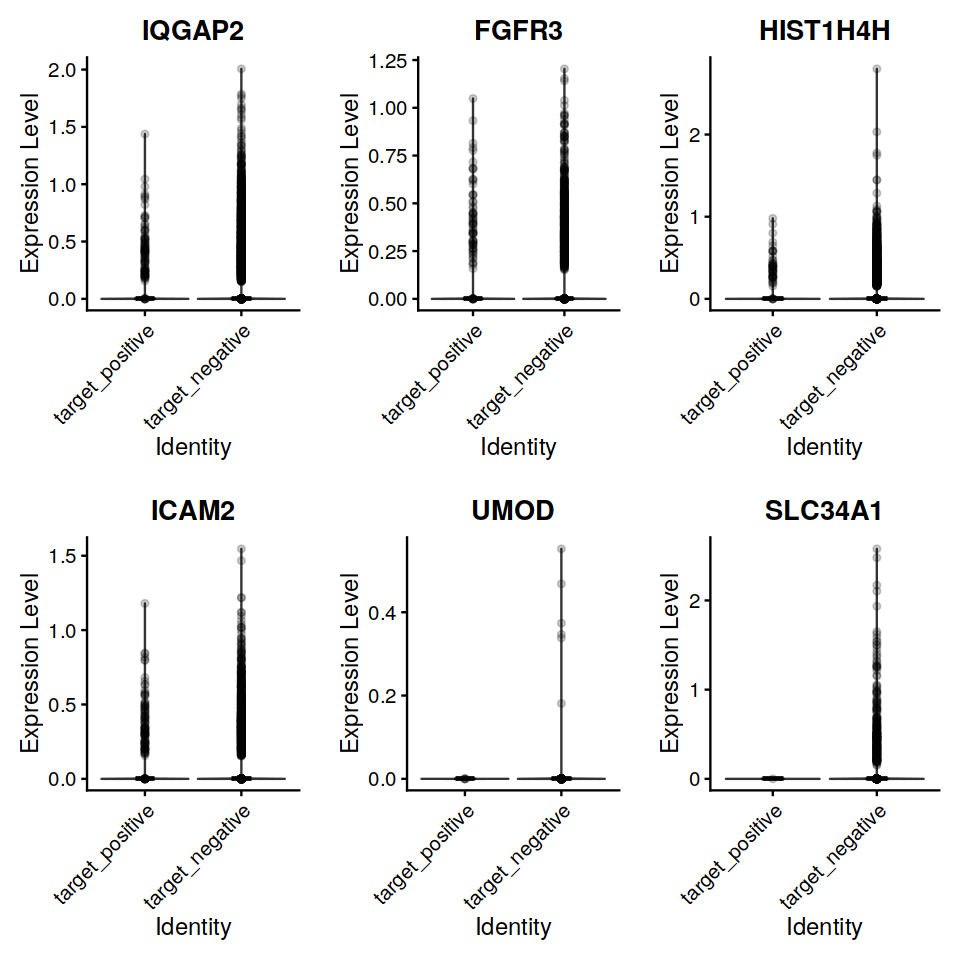

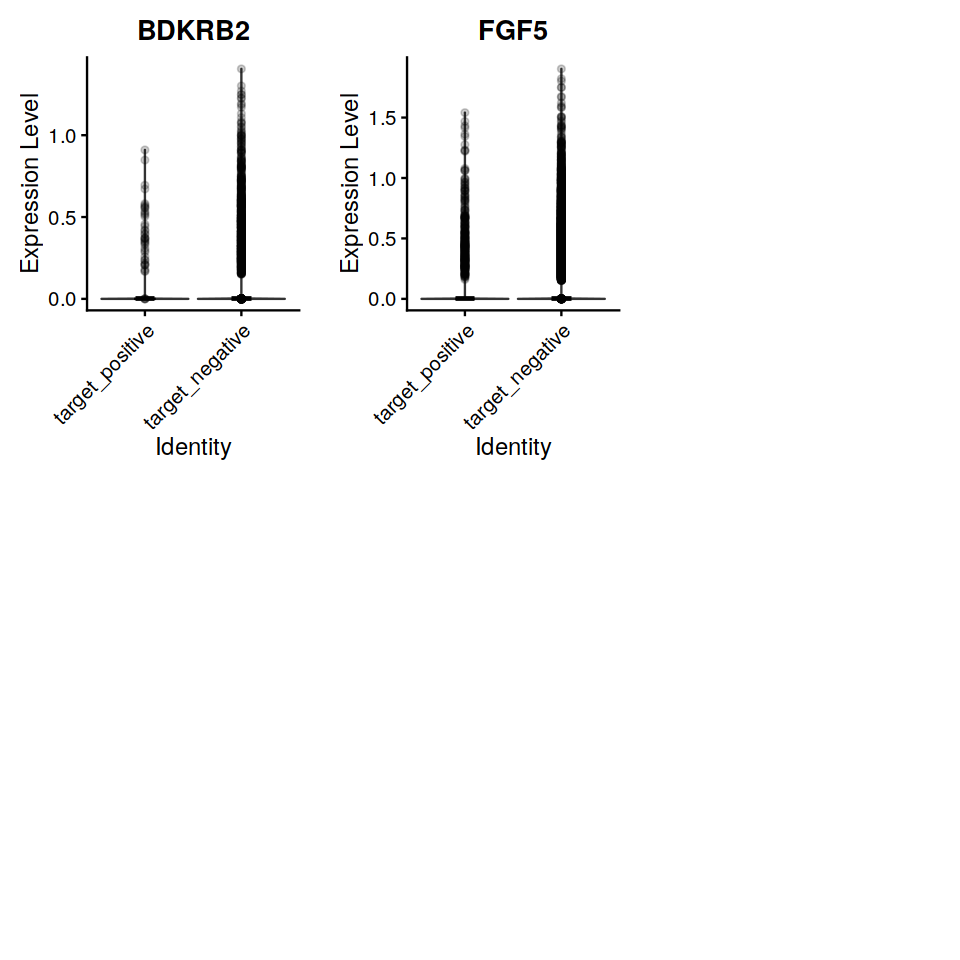

In [317]:
targets = unique(filter(df_guide, subclass=='tss')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=8, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

[1] "FTH1"
FTH1-1a   203 
FTH1-2a   1605 
FTH1-1b   1682 
FTH1-2b   1682 
Guide+ = 1682 ; Guide- = 44369 
[1] "PLIN3"
PLIN3-1a   333 
PLIN3-2a   596 
PLIN3-1b   768 
PLIN3-2b   888 
Guide+ = 888 ; Guide- = 45163 
[1] "TKT"
TKT-1a   360 
TKT-2a   653 
TKT-1b   806 
TKT-2b   928 
Guide+ = 928 ; Guide- = 45123 
[1] "LGALS3"
LGALS3-1a   397 
LGALS3-2a   696 
LGALS3-1b   802 
LGALS3-2b   894 
Guide+ = 894 ; Guide- = 45157 
[1] "CSTB"
CSTB-1a   417 
CSTB-2a   814 
CSTB-1b   934 
CSTB-2b   1016 
Guide+ = 1016 ; Guide- = 45035 
[1] "CTSB"
CTSB-1a   337 
CTSB-2a   652 
CTSB-1b   770 
CTSB-2b   861 
Guide+ = 861 ; Guide- = 45190 
[1] "KLF6"
KLF6-1a   336 
KLF6-2a   721 
KLF6-1b   828 
KLF6-2b   930 
Guide+ = 930 ; Guide- = 45121 


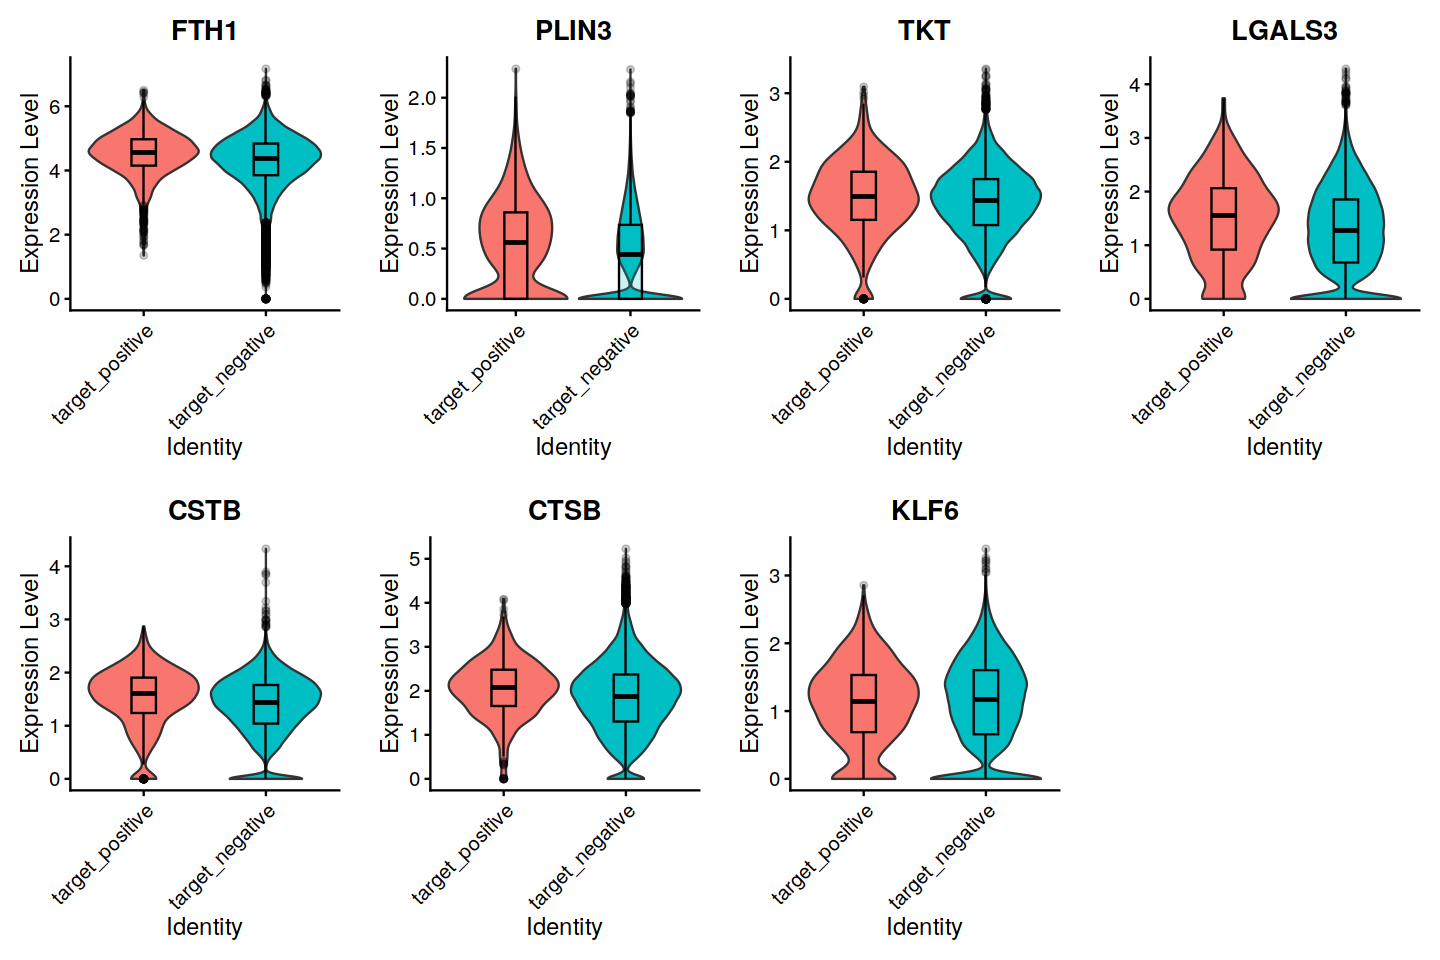

In [318]:
targets = unique(filter(df_guide, subclass=='de_control')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=4, nrow = 2)

## CKD DE 

[1] "DE22"
Guide+ = 1921 ; Guide- = 44130 
[1] "DE15"
Guide+ = 974 ; Guide- = 45077 


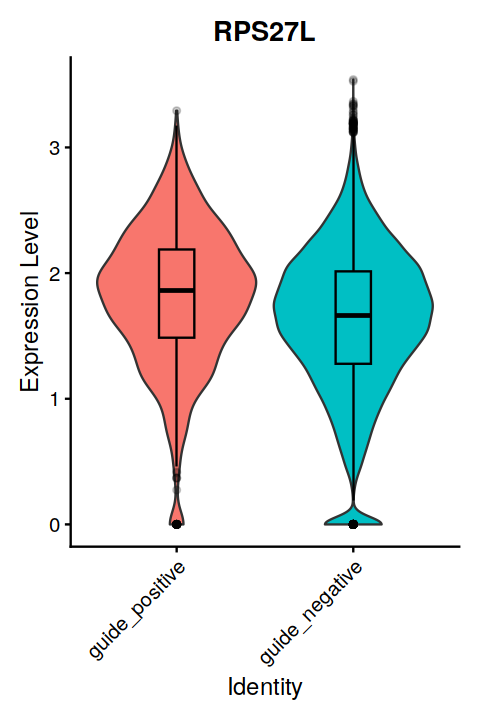

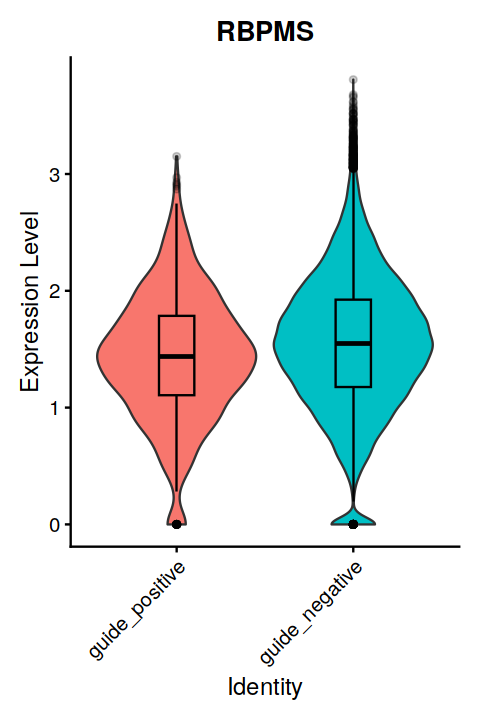

In [319]:
target = "DE22"
regulated_gene = "RPS27L"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     



target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt1) 
print(plt2)

### Violin plots for all DEs

In [320]:
vlnplot_for_de_targets <- function(seurat_obj, df_guide, perturbed_cells_by_guide, df_target_vs_regulated) {
    plt_list = list()
    for(i in 1:nrow(df_target_vs_regulated)) {
        target = df_target_vs_regulated[i, 'target']
        regulated_gene = df_target_vs_regulated[i, 'de_gene']
        my_p_val = df_target_vs_regulated[i, 'p_val_adj_mine']
        my_p_val = formatC(my_p_val, format = "e", digits = 1)
        title = paste0(target, ": ", regulated_gene)
        subtitle = paste("Adjusted p =", my_p_val)
        
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_dummy <- mark_target_pos_neg(
            seurat_rna,
            perturbed_cells_by_guide, 
            guides, 
            print_counts = F
        )

        options(repr.plot.width=5, repr.plot.height=4)
        plt <- VlnPlot(
            object = seurat_dummy,
            features =  regulated_gene, 
            idents = NULL, 
            pt.size = 0., 
            sort = F, 
            ncol = 1,    
        ) + 
            geom_boxplot(width=.2, color="black", alpha=0.2) + theme(legend.position = 'none') +
            labs(title = title, subtitle = subtitle)
        plt_list[[i]] = plt
    }
    plt_list
}


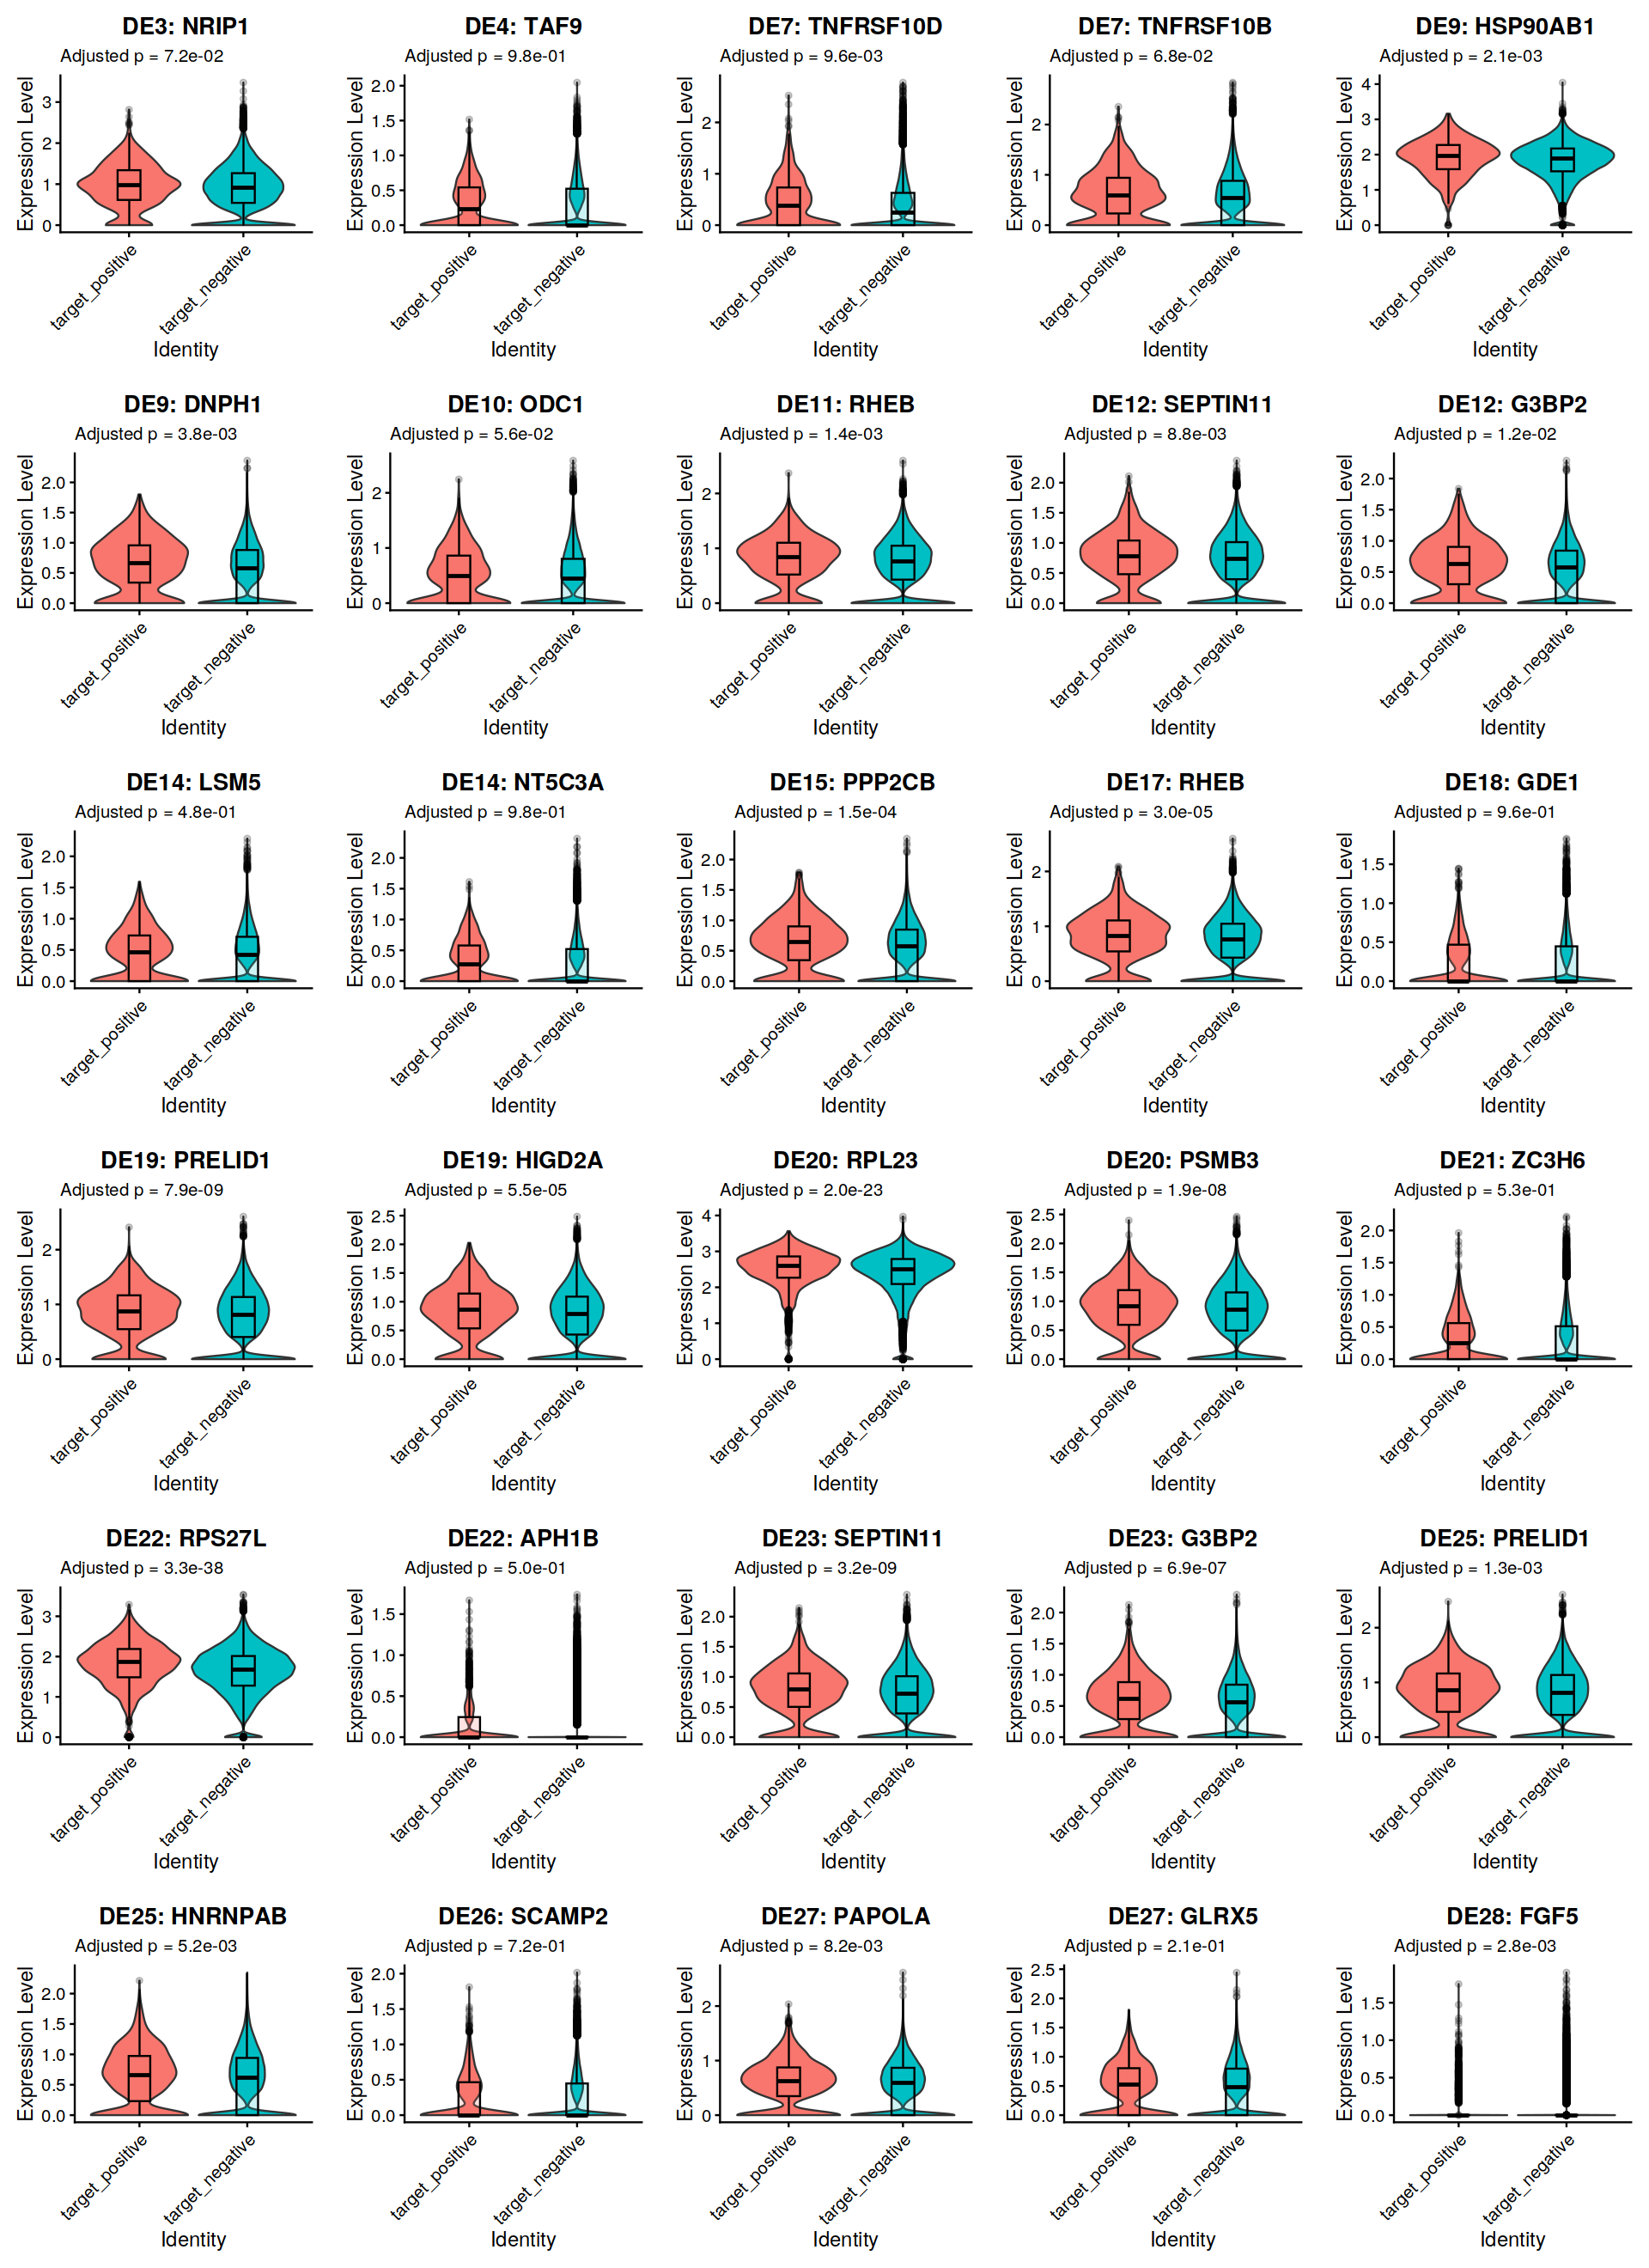

In [321]:
df_top_distal_hits = df_top_hits %>% filter(label == "CKD DE")
df_target_vs_regulated = df_top_hits %>% filter(label == "CKD DE")
plots = vlnplot_for_de_targets(seurat_rna, df_guide, perturbed_cells_by_guide, df_top_distal_hits)

options(repr.plot.width=16, repr.plot.height=22)
ggarrange(plotlist=plots, ncol=5, nrow = 6)


# Debug